# Creating final tables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [2]:
sns.set(rc = {
    'axes.facecolor':'#1e1e1e',
    'axes.edgecolor': 'grey',
    'text.color': 'grey',
    'figure.facecolor':'#1e1e1e',
    'axes.labelcolor': 'grey',
    'xtick.color': 'grey',
    'ytick.color': 'grey',
    'grid.color': 'grey',
    'grid.linestyle': 'dotted',
})

## Importing internal data

In [97]:
Vehicule = pd.read_csv('Clean Data/VehiculeNew.csv').drop(columns = ['Unnamed: 0'])
Assure = pd.read_csv('Clean Data/Assure.csv')
BonusMalus = pd.read_csv('Clean Data/BonusMalus.csv')
Police = pd.read_csv('Clean Data/Police.csv')
Sinistre = pd.read_csv('Clean Data/Sinistre.csv')

## Features to use in machine learning algorithms
- Police
    - policeId (index)
    - typePolice
    - naturePolice

- Vehicule
    - puissanceFiscale
    - typeImmatriculation
    - energie
    - marque
    - usage

- Assure
    - anneesExp (2020 - Année d'obtention du permis)
    - gouvernorat

- BonusMalus
    - classeBonusMalus (target)

- Sinistre
    - nombreSinistres ?

## Starting with Police

In [98]:
final_df = Police[['policeId', 'typePolice', 'naturePolice']].copy()

print(final_df.shape)
print('-'*158)
final_df.head()

(94620, 3)
--------------------------------------------------------------------------------------------------------------------------------------------------------------


,policeId,typePolice,naturePolice
0,61519,I,T
1,61553,I,R
2,61587,I,R
3,61787,I,R
4,61796,I,R


## Joining Vehicule on `policeId`

In [99]:
poop = Vehicule.set_index('policeId')[['puissanceFiscal', 'typeImmatriculation', 'energie', 'marque', 'usage']]
final_df = final_df.join(poop, on = 'policeId', how = 'left')

print(final_df.shape)
print('-'*158)
final_df.head()

(94620, 8)
--------------------------------------------------------------------------------------------------------------------------------------------------------------


,policeId,typePolice,naturePolice,puissanceFiscal,typeImmatriculation,energie,marque,usage
0,61519,I,T,9.0,TU,GASOIL,IVECO,Agricole1 véhicule dont le PTC < 3500 kg
1,61553,I,R,5.0,TU,ESSENCE,VOLKSWAGEN,Auto-Ecole
2,61587,I,R,5.0,TU,GASOIL,PEUGEOT,Taxi
3,61787,I,R,6.0,TU,ESSENCE,MAZDA,Privé et professionnel
4,61796,I,R,5.0,TU,GASOIL,CITROEN,Utilitaire 1 véhicule dont le PTC < 3500 kg (y...


## Joining BonusMalus on `policeId`

In [100]:
poop = BonusMalus.set_index('vehiculeId')[['assureId', 'classeBonusMalus']]
final_df = final_df.join(poop, on = 'policeId', how = 'left')

print(final_df.shape)
print('-'*158)
final_df.head()

(94646, 10)
--------------------------------------------------------------------------------------------------------------------------------------------------------------


,policeId,typePolice,naturePolice,puissanceFiscal,typeImmatriculation,energie,marque,usage,assureId,classeBonusMalus
0,61519,I,T,9.0,TU,GASOIL,IVECO,Agricole1 véhicule dont le PTC < 3500 kg,NaN,NaN
1,61553,I,R,5.0,TU,ESSENCE,VOLKSWAGEN,Auto-Ecole,NaN,NaN
2,61587,I,R,5.0,TU,GASOIL,PEUGEOT,Taxi,57840.0,11.0
3,61787,I,R,6.0,TU,ESSENCE,MAZDA,Privé et professionnel,NaN,NaN
4,61796,I,R,5.0,TU,GASOIL,CITROEN,Utilitaire 1 véhicule dont le PTC < 3500 kg (y...,NaN,NaN


In [101]:
final_df.dropna(inplace = True)

print(final_df.shape)
print('-'*158)
final_df.head()

(3370, 10)
--------------------------------------------------------------------------------------------------------------------------------------------------------------


,policeId,typePolice,naturePolice,puissanceFiscal,typeImmatriculation,energie,marque,usage,assureId,classeBonusMalus
2,61587,I,R,5.0,TU,GASOIL,PEUGEOT,Taxi,57840.0,11.0
60,34949,I,R,4.0,TU,GASOIL,PEUGEOT,Taxi,32531.0,3.0
63,35451,I,R,5.0,TU,ESSENCE,FIAT,Taxi,33033.0,3.0
70,35826,I,R,6.0,TU,GASOIL,VOLKSWAGEN,Taxi,33406.0,4.0
75,36094,I,R,4.0,TU,ESSENCE,VOLKSWAGEN,Auto-Ecole,33676.0,4.0


### We are left with only 3370 lines !

## Joining Assure on `assureId`
### Creating the new column `anneExp` <br/> First, there are some errors that need to be corrected

In [102]:
Assure.where(Assure['dateObtentionPermis'].str.startswith('2059')).dropna(how = 'all').head()

,assureId,codeTypePieceIdentite,dateObtentionPermis,codePostal,gouvernorat
62,138735.0,2.0,2059-10-20,2084.0,Ben Arous
245,1092752.0,1.0,2059-01-23,3000.0,Sfax
883,1044789.0,1.0,2059-01-31,1004.0,Tunis
1295,1215273.0,1.0,2059-02-26,2013.0,Ben Arous
1296,381997.0,1.0,2059-03-26,3000.0,Sfax


In [103]:
tmp = Assure['dateObtentionPermis'].values
for i in range(len(tmp)):
    if int(tmp[i][:4]) >= 2020:
        tmp[i] = tmp[i].replace('20', '19', 1)
Assure['dateObtentionPermis'] = tmp

In [104]:
permis = Assure['dateObtentionPermis'].values
for i in range(len(permis)):
    permis[i] = 2020 - int(permis[i][:4])

Assure['dateObtentionPermis'] = Assure['dateObtentionPermis'].astype(np.int64)

Assure.rename(columns = {
    'dateObtentionPermis': 'anneesExp'
}, inplace = True)

In [105]:
Assure.head()

,assureId,codeTypePieceIdentite,anneesExp,codePostal,gouvernorat
0,1378074,1,18,2080,Ariana
1,28443,1,38,1110,Manouba
2,886858,1,37,1068,Tunis
3,894479,1,37,2052,Tunis
4,180741,1,38,1013,Tunis


### Joining Assure on `assureId`

In [106]:
poop = Assure.set_index('assureId')[['anneesExp', 'gouvernorat']]
final_df = final_df.join(poop, on = 'assureId', how = 'left').drop(columns = ['assureId'])

print(final_df.shape)
print('-'*158)
final_df.head()

(3370, 11)
--------------------------------------------------------------------------------------------------------------------------------------------------------------


,policeId,typePolice,naturePolice,puissanceFiscal,typeImmatriculation,energie,marque,usage,classeBonusMalus,anneesExp,gouvernorat
2,61587,I,R,5.0,TU,GASOIL,PEUGEOT,Taxi,11.0,NaN,NaN
60,34949,I,R,4.0,TU,GASOIL,PEUGEOT,Taxi,3.0,35.0,Sidi Bouzid
63,35451,I,R,5.0,TU,ESSENCE,FIAT,Taxi,3.0,16.0,Tunis
70,35826,I,R,6.0,TU,GASOIL,VOLKSWAGEN,Taxi,4.0,NaN,NaN
75,36094,I,R,4.0,TU,ESSENCE,VOLKSWAGEN,Auto-Ecole,4.0,NaN,NaN


In [107]:
final_df.dropna(inplace = True)

print(final_df.shape)
print('-'*158)
final_df.head()

(1060, 11)
--------------------------------------------------------------------------------------------------------------------------------------------------------------


,policeId,typePolice,naturePolice,puissanceFiscal,typeImmatriculation,energie,marque,usage,classeBonusMalus,anneesExp,gouvernorat
60,34949,I,R,4.0,TU,GASOIL,PEUGEOT,Taxi,3.0,35.0,Sidi Bouzid
63,35451,I,R,5.0,TU,ESSENCE,FIAT,Taxi,3.0,16.0,Tunis
77,36285,I,R,5.0,TU,ESS-GAZ GPL,RENAULT,Taxi,1.0,16.0,Tunis
79,36362,I,R,5.0,TU,ESSENCE,RENAULT,Taxi,2.0,27.0,Manouba
99,97019,I,R,5.0,TU,GASOIL,CITROEN,Utilitaire 1 véhicule dont le PTC < 3500 kg (y...,3.0,21.0,Ariana


### We are left with 1060 lines (-_-)

## Renaming columns

In [108]:
final_df.rename(columns = {
    'puissanceFiscal': 'puissanceFiscalVoiture',
    'energie': 'energieVoiture',
    'marque': 'marqueVoiture',
    'usage': 'usageVoiture',
    'anneesExp': 'anneesExpAssure',
    'gouvernorat': 'gouvernoratAssure'
}, inplace = True)

final_df.head()

,policeId,typePolice,naturePolice,puissanceFiscalVoiture,typeImmatriculation,energieVoiture,marqueVoiture,usageVoiture,classeBonusMalus,anneesExpAssure,gouvernoratAssure
60,34949,I,R,4.0,TU,GASOIL,PEUGEOT,Taxi,3.0,35.0,Sidi Bouzid
63,35451,I,R,5.0,TU,ESSENCE,FIAT,Taxi,3.0,16.0,Tunis
77,36285,I,R,5.0,TU,ESS-GAZ GPL,RENAULT,Taxi,1.0,16.0,Tunis
79,36362,I,R,5.0,TU,ESSENCE,RENAULT,Taxi,2.0,27.0,Manouba
99,97019,I,R,5.0,TU,GASOIL,CITROEN,Utilitaire 1 véhicule dont le PTC < 3500 kg (y...,3.0,21.0,Ariana


## Shifting the target variable (`classeBonusMalus`) to the edge of the dataframe

In [109]:
tmp = final_df.copy()
tmp.drop(columns = ['classeBonusMalus'], inplace = True)
tmp['classeBonusMalus'] = final_df['classeBonusMalus'].values
final_df = tmp

final_df.head()

,policeId,typePolice,naturePolice,puissanceFiscalVoiture,typeImmatriculation,energieVoiture,marqueVoiture,usageVoiture,anneesExpAssure,gouvernoratAssure,classeBonusMalus
60,34949,I,R,4.0,TU,GASOIL,PEUGEOT,Taxi,35.0,Sidi Bouzid,3.0
63,35451,I,R,5.0,TU,ESSENCE,FIAT,Taxi,16.0,Tunis,3.0
77,36285,I,R,5.0,TU,ESS-GAZ GPL,RENAULT,Taxi,16.0,Tunis,1.0
79,36362,I,R,5.0,TU,ESSENCE,RENAULT,Taxi,27.0,Manouba,2.0
99,97019,I,R,5.0,TU,GASOIL,CITROEN,Utilitaire 1 véhicule dont le PTC < 3500 kg (y...,21.0,Ariana,3.0


## Encoding categorical variables & creating dummy variables

### Encoding categorical variables (those with only two distinct values)
- typePolice
- naturePolice

In [110]:
final_df.replace({
    'typePolice': {'I': 1, 'F': 2},
    'naturePolice': {'R': 1, 'T': 4}
}, inplace = True)

final_df.head()

,policeId,typePolice,naturePolice,puissanceFiscalVoiture,typeImmatriculation,energieVoiture,marqueVoiture,usageVoiture,anneesExpAssure,gouvernoratAssure,classeBonusMalus
60,34949,1,1,4.0,TU,GASOIL,PEUGEOT,Taxi,35.0,Sidi Bouzid,3.0
63,35451,1,1,5.0,TU,ESSENCE,FIAT,Taxi,16.0,Tunis,3.0
77,36285,1,1,5.0,TU,ESS-GAZ GPL,RENAULT,Taxi,16.0,Tunis,1.0
79,36362,1,1,5.0,TU,ESSENCE,RENAULT,Taxi,27.0,Manouba,2.0
99,97019,1,1,5.0,TU,GASOIL,CITROEN,Utilitaire 1 véhicule dont le PTC < 3500 kg (y...,21.0,Ariana,3.0


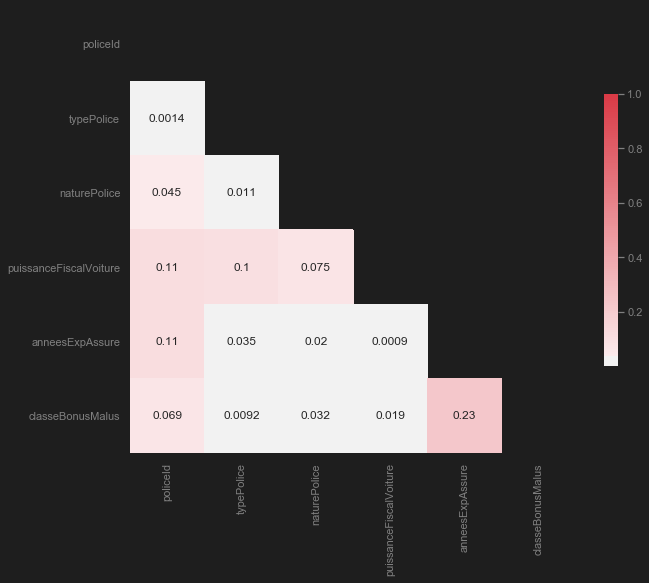

In [111]:
correlation = abs(final_df.corr())

mask = np.zeros_like(correlation, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize = (10, 10))

cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(correlation, mask = mask, cmap = cmap, vmax = 1, center = 0,
            square = True, linewidths = 0, cbar_kws = {"shrink": .5}, annot = True);

In [112]:
categ = ['typeImmatriculation', 'energieVoiture', 'marqueVoiture', 'usageVoiture', 'gouvernoratAssure']

tmp = pd.get_dummies(final_df[categ])

tmp['typePolice'] = final_df['typePolice'].values
tmp['naturePolice'] = final_df['naturePolice'].values
tmp['puissanceFiscalVoiture'] = final_df['puissanceFiscalVoiture'].values
tmp['anneesExpAssure'] = final_df['anneesExpAssure'].values

tmp['classeBonusMalus'] = final_df['classeBonusMalus'].values

final_df = tmp

final_df.head()

,typeImmatriculation_ES,typeImmatriculation_RS,typeImmatriculation_TRAC,typeImmatriculation_TU,energieVoiture_ESS-GAZ GPL,energieVoiture_ESSENCE,energieVoiture_GASOIL,marqueVoiture_AUDI,marqueVoiture_BERLIET,marqueVoiture_BMW,...,gouvernoratAssure_Siliana,gouvernoratAssure_Sousse,gouvernoratAssure_Tataouine,gouvernoratAssure_Tunis,gouvernoratAssure_Zaghouan,typePolice,naturePolice,puissanceFiscalVoiture,anneesExpAssure,classeBonusMalus
60,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,1,4.0,35.0,3.0
63,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,1,5.0,16.0,3.0
77,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,1,1,5.0,16.0,1.0
79,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,1,5.0,27.0,2.0
99,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,1,5.0,21.0,3.0


In [116]:
final_df.to_csv('Clean Data/Final.csv')